# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

import numpy as np

In [2]:
%%time
print(np.random.rand(), 'hello')

0.8550565657045086 hello
CPU times: user 887 µs, sys: 773 µs, total: 1.66 ms
Wall time: 2.41 ms


In [3]:
!ls sample_data


anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

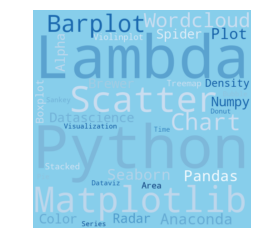

In [4]:
# TODO - your code here
# Use what we did live in lecture as an example

from wordcloud import WordCloud
import matplotlib.pyplot as plt
 

text=("Python Python Python Matplotlib Matplotlib Seaborn Lambda Lambda Lambda Plot Anaconda Pandas Datascience Numpy Spider Radar Scatter Alpha Color Brewer Density Scatter Barplot Barplot Boxplot Violinplot Treemap Stacked Area Chart Chart Visualization Dataviz Donut Pie Time-Series Wordcloud Wordcloud Sankey Bubble")
 
wordcloud = WordCloud(width=480, height=480, background_color='skyblue', colormap="Blues").generate(text)
 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.